Import packages

In [1]:
using JuMP, HiGHS, Ipopt

Utility functions:

solve_evader_OCP - solve the optimal control problem where the evader avoids the pursuer with a cost x'*x and bounded turning rate

solve_pursuer_OCP - solve the optimal control problem where the pursuer tracks the evader with a cost x'*x and bounded turning rate

In [2]:
# function: solve_evader_OCP
# objective: given the state of an evader and state of a pursuer, find the optimal control for the evader to avoid the pursuer 
# inputs: 
#   - model: OCP solver model
#   - sim_params: struct of simulation parameters
#   - __pursuer: dubins car object for pursuer
#   - __evader: dubins car object for evader
function solve_evader_OCP(model, sim_params, __pursuer, __evader)


    N = sim_params.N
    Δt = sim_params.Δt


    x_pursuer = __pursuer.x_true[1]
    y_pursuer = __pursuer.x_true[2]

    x0 = __evader.x_measured[1]
    y0 = __evader.x_measured[2]
    θ0 = __evader.x_measured[3]

    v = __evader.v
    u_max = __evader.u_max

    # Decision variables
    @variable(model, x[1:N+1])      # x position
    @variable(model, y[1:N+1])      # y position
    @variable(model, θ[1:N+1])      # orientation
    @variable(model, ω[1:N])        # control input (turning rate)

    # Objective function (quadratic cost on position and control) --> maximize distance to pursuer
    @objective(model, Min, 
        -sum((x[k] - x_pursuer)^2 + (y[k] - y_pursuer)^2 for k in 1:N)) + sum(ω[k]^2 for k in 1:N)

    # Initial conditions
    @constraint(model, x[1] == x0)
    @constraint(model, y[1] == y0)
    @constraint(model, θ[1] == θ0)

    # Dubins car dynamics constraints
    for k in 1:N
        @constraint(model, x[k+1] == x[k] + v * cos(θ[k]) * Δt)
        @constraint(model, y[k+1] == y[k] + v * sin(θ[k]) * Δt)
        @constraint(model, θ[k+1] == θ[k] + ω[k] * Δt)

        # bounded control input
        @constraint(model, -u_max <= ω[k] <= u_max)

    end

    # Solve the optimization problem
    optimize!(model)

    # Extract results
    x_opt = value.(x)
    y_opt = value.(y)
    θ_opt = value.(θ)
    ω_opt = value.(ω)

    return x_opt,y_opt,θ_opt,ω_opt
end

# function: solve_pursuer_OCP
# objective: given the state of an evader and state of a pursuer, find the optimal control for the pursuer to catch the evader 
# inputs: 
#   - model: OCP solver model
#   - sim_params: struct of simulation parameters
#   - __pursuer: dubins car object for pursuer
#   - __evader: dubins car object for evader
function solve_pursuer_OCP(model, sim_params, __pursuer, __evader)
    N = sim_params.N
    Δt = sim_params.Δt

    x_evader = __evader.x_true[1]
    y_evader = __evader.x_true[2]
    θ_evader = __evader.x_true[3]

    x0 = __pursuer.x_true[1]
    y0 = __pursuer.x_true[2]
    θ0 = __pursuer.x_true[3]

    v = __pursuer.v
    u_max = __pursuer.u_max

    # Decision variables
    @variable(model, x[1:N+1])      # x position
    @variable(model, y[1:N+1])      # y position
    @variable(model, θ[1:N+1])      # orientation
    @variable(model, ω[1:N])        # control input (turning rate)

    # Objective function (quadratic cost on position and control)
    @objective(model, Min, 
        sum((x[k] - x_evader)^2 + (y[k] - y_evader)^2 for k in 1:N))

    # Initial conditions
    @constraint(model, x[1] == x0)
    @constraint(model, y[1] == y0)
    @constraint(model, θ[1] == θ0)

    # Dubins car dynamics constraints
    for k in 1:N
        @constraint(model, x[k+1] == x[k] + v * cos(θ[k]) * Δt)
        @constraint(model, y[k+1] == y[k] + v * sin(θ[k]) * Δt)
        @constraint(model, θ[k+1] == θ[k] + ω[k] * Δt)

        # bounded control input
        @constraint(model, -u_max <= ω[k] <= u_max)
    end
    
    # Solve the optimization problem
    optimize!(model)

    # Extract results
    x_opt = value.(x)
    y_opt = value.(y)
    θ_opt = value.(θ)
    ω_opt = value.(ω)

    return x_opt,y_opt,θ_opt,ω_opt
end

solve_pursuer_OCP (generic function with 1 method)

In [3]:
include("dynamics\\DubinsCar.jl")

@kwdef mutable struct Parameters
    N::Int64
    Δt::Float64
    T::Int64
end

# Parameters
T = 20                   # Total sim time [seconds]
Δt = 0.1                 # Time step
N = 0.2*(T/Δt)           # Time horizon

x0_pursuer = -1.5         # adversary x position
y0_pursuer = 0.0         # adversary y position
θ0_pursuer = pi/2        # adversary orientation
v_pursuer= 1.5           # Fixed pursuer forward velocity
up_max = 0.5             # Bound on input (turn rate)

x0_evader = 0.0          # Initial evader x position
y0_evader = 0.0          # Initial evader y position
θ0_evader = pi/2         # Initial evader orientation
v_evader = 0.75           # Fixed evader forward velocity
ue_max = 1.0             # Bound on input (turn rate)

pursuer_init_state = Vector{Float64}([x0_pursuer, y0_pursuer, θ0_pursuer])
evader_init_state = Vector{Float64}([x0_evader, y0_evader, θ0_evader])



sim_params = Parameters(N,Δt,T)

# pursuer and evader objects
__pursuer = Dubins_Car(f,h,v_pursuer,pursuer_init_state, pursuer_init_state, up_max)
__evader = Dubins_Car(f,h,v_evader,evader_init_state, evader_init_state,ue_max)

evader_model = Model(Ipopt.Optimizer)
pursuer_model = Model(Ipopt.Optimizer)


A JuMP Model
├ solver: Ipopt
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [4]:
x_opt,y_opt,θ_opt,ω_opt = solve_evader_OCP(evader_model, sim_params, __pursuer, __evader);
xp_opt, yp_opt, θp_opt, ωp_opt = solve_pursuer_OCP(pursuer_model, sim_params, __pursuer, __evader);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      363
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      160

Total number of variables............................:      163
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      123
Total number of inequality c

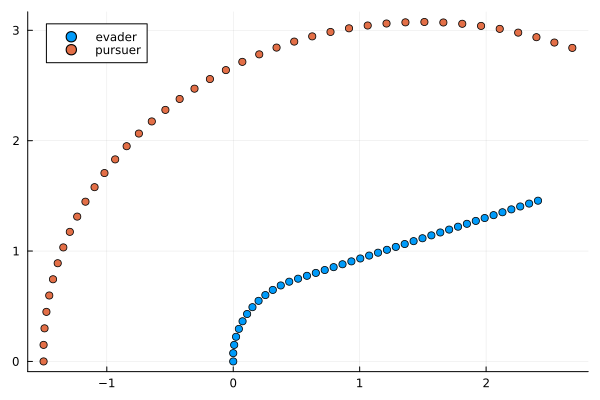

In [5]:
using Plots

plot(x_opt, y_opt, seriestype=:scatter,label="evader")
plot!(xp_opt, yp_opt, seriestype=:scatter,label="pursuer")

Implement MPC finite-horizon simulation of pursuer/evader

In [6]:
K = Int64(sim_params.T / sim_params.Δt)
xₚ = fill(0.0f0, (3,K))
xₑ = fill(0.0f0, (3,K))

xₚ[:,1] = pursuer_init_state
xₑ[:,1] = evader_init_state


for t in 1:K-1

    ## Solve the optimal control problem for both pursuer and evader
    evader_model = Model(Ipopt.Optimizer)
    pursuer_model = Model(Ipopt.Optimizer)

    ## We let the evader play first

    # solve the evader OCP 
    _,_,_,ue_opt = solve_evader_OCP(evader_model, sim_params, __pursuer, __evader);

    # Extract the first optimal control value
    uₑ = ue_opt[1]

    # Update dubins car and store position
    xₑ_kplus1 = __evader.f(Vector{Float64}(xₑ[:,t]),uₑ,0.0,__evader.v,Δt)
    xₑ[:,t+1] = xₑ_kplus1
    __evader.x_true = xₑ_kplus1
    __evader.x_measured = xₑ_kplus1


    ## Now we let the disturbance play second
    _,_,_,up_opt = solve_pursuer_OCP(pursuer_model, sim_params, __pursuer, __evader);

    # extract first optimal control value
    uₚ = up_opt[1]

    # Update dubins car and store position
    xₚ_kplus1  = __pursuer.f(Vector{Float64}(xₚ[:,t]),uₚ,0.0,__pursuer.v,Δt)
    xₚ[:,t+1] = xₚ_kplus1
    __pursuer.x_true = xₚ_kplus1
    __pursuer.x_measured = xₚ_kplus1


    println(t)
end




This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      363
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      160

Total number of variables............................:      163
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      123
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       40
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -9.0000000e+01 1.57e+00 1.42e-14  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Excessive output truncated after 525053 bytes.

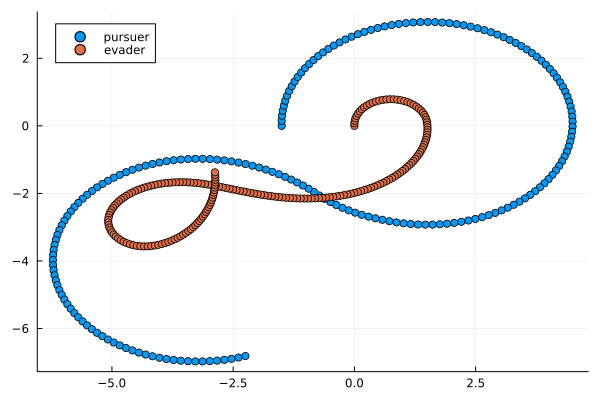

In [7]:
plot(xₚ[1,:],xₚ[2,:],seriestype=:scatter,label="pursuer")
plot!(xₑ[1,:],xₑ[2,:],seriestype=:scatter,label="evader")

Plots.AnimatedGif("c:\\Users\\remba\\UCSD\\SAS Lab\\SSA_Julia\\pursuit_evasion.gif")
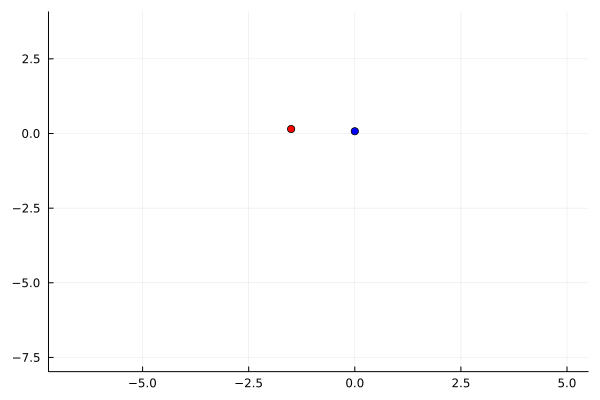

In [8]:
xmin = minimum(vcat(xₚ[1,:], xₑ[1,:]))
ymin = minimum(vcat(xₚ[2,:], xₑ[2,:]))

xmax = maximum(vcat(xₚ[1,:], xₑ[1,:]))
ymax = maximum(vcat(xₚ[2,:], xₑ[2,:]))


function animate_frame(i)
    plot((xₚ[1,i],xₚ[2,i]),seriestype=:scatter, label = false, mc=:red)
    plot!((xₑ[1,i],xₑ[2,i]),seriestype=:scatter, label = false,mc=:blue)
    xlims!(xmin-1,xmax+1)
    ylims!(ymin-1,ymax+1)
end

plot((xₚ[1,1],xₚ[2,1]),seriestype=:scatter, label = false, mc=:red)
plot!((xₑ[1,1],xₑ[2,1]),seriestype=:scatter, label = false,mc=:blue)

anim = @animate for i in 2:K-1
    animate_frame(i)
end
gif(anim, "pursuit_evasion.gif",fps=100)


Now we introduce some uncertainty. Let's say that we do not know the true state of the evader, but we know the true state of the pursuer and the pursuer knows the true state of the evader.

Since we do not know the true state of the evader, we can estimate the state of the evader using a bootstrap particle filter

In [9]:
## Bootstrap Partilce Filter (additive Gaussian)

Base.@kwdef mutable struct Particle_Filter
    model::Dubins_Car
    TimeUpdate::Function
    MeasurementUpdate::Function
    Resampler::Function
    likelihoods::Vector
    particles::Array
end

function TimeUpdate(x, model, u, w)
    x_plus = Array{Float64}(undef, size(x,1), size(x,2))
    for i = axes(x,2)
        x_plus[:,i] = model.f(x[:,i],u,w[i], __evader.v, Δt)
    end
    return x_plus
end

function MeasurementUpdate!(particle_filter, model, y, var)
    x = particle_filter.particles
    likelihoods = Vector(fill(0.0,(L)))
    for i = axes(x,2)
        err = y-model.h(x[:,i],[0.0,0.0])
        likelihoods[i] = -1/2 * err' * I*var * err
    end
    particle_filter.likelihoods = particle_filter.likelihoods.*likelihoods./(sum(particle_filter.likelihoods.*likelihoods))
end

function Resampler(particle_filter)
    x_resampled = fill(NaN, size(particle_filter.particles))
    CDF = cumsum(particle_filter.likelihoods)
    for i = axes(x_resampled,2)
        x_resampled[:,i] = particle_filter.particles[:,findfirst(CDF .>= rand(1))]
    end
    particle_filter.particles = x_resampled
    particle_filter.likelihoods = Vector(fill(1,(L)))
end

Resampler (generic function with 1 method)

In [10]:
using CUDA, LinearAlgebra, Distributions

####
# function: gpu_generate_Xi
# input: 
#   - L = number of particles
#   - n = number of dimensions of the state
#   - μ = mean state  
#   - var = covariance
# output: Ξ₀ = Array of randomly sampled states, size: [2 x L]
###
function gpu_generate_Xi(L :: Int64, n :: Int64, μ::Vector{Float64}, var)
    # Gaussian Density with mean vector μ_x0 and covariance matrix Σ_x0
    μ_x0 = CuArray(μ)
    Σ_x0 = (var*I)

    # randomly sample initial states Ξ following Gaussian density
    Ξ₀ = CuArray{Float64}(undef,n,L)
    Ξ₀ = μ_x0.+sqrt(Σ_x0)*CUDA.randn(n,L)
    return (Ξ₀)
end

L = 1000                        # number of particles               
n = 2                           # dimension of states
μ = [pursuer_init_state[1],     # mean initial state
    pursuer_init_state[2]]
R = 0.25                        # measurement variance
Σ = 0.10                        # process variance

Ξ = vcat(Array(gpu_generate_Xi(L, n, μ, R)), fill(pursuer_init_state[3],(L))')
pf = Particle_Filter(__evader, TimeUpdate, MeasurementUpdate!, Resampler, Vector(fill(1,(L))) , Ξ)
x_star = mean(pf.particles[1:2,:], dims=2)


2×1 Matrix{Float64}:
 -1.5008242589405272
 -0.020968666661083716

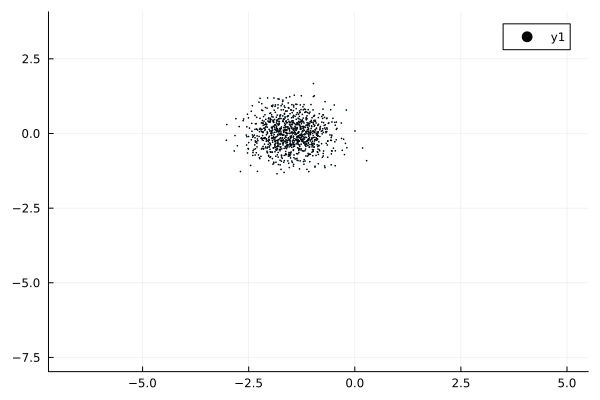

In [11]:
plot(Ξ[1,:], Ξ[2,:], seriestype=:scatter,ms=0.5)
xlims!(xmin-1,xmax+1)
ylims!(ymin-1,ymax+1)

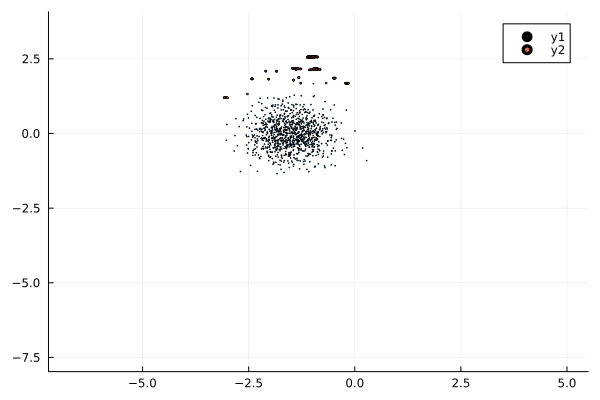

In [24]:

function propagate_bootstrap_pf(pf::Particle_Filter, dubins_car::Dubins_Car, u::Float64, Σ, R, L, y)
    # randomly generated process noise
    w = randn(L)*sqrt(Σ)

    # propagate all particles through one time step of dynamics
    Xi_plus = pf.TimeUpdate(pf.particles, dubins_car, u, w)
    pf.particles = Xi_plus

    # calculate measurement likelihoods
    pf.MeasurementUpdate(pf, dubins_car, y, R)

    # resample particles to avoid depletion
    pf.Resampler(pf)
end

x_true = vcat((μ + sqrt(Σ)*randn(2)), 0)

__evader.x_true = __evader.f(x_true, 0.0, Σ, __evader.v, Δt)

v = sqrt(R)*randn(2)
y = x_true[1:2] + v
propagate_bootstrap_pf(pf, __evader, 0.0, Σ, R, L, y)

plot(Ξ[1,:], Ξ[2,:], seriestype=:scatter,ms=0.5)
plot!(pf.particles[1,:], pf.particles[2,:], seriestype=:scatter, ms = 1.0)
xlims!(xmin-1,xmax+1)
ylims!(ymin-1,ymax+1)

In [13]:

# ### MPC loop

# ## Evader plays first:
# # - certainty equivalence using the conditional mean
# # - solve_evader_OCP using conditional mean as the scatter
# # - extract first control value
# # - apply control to true evader state 
# # - propagate and resample particle filter

# ## Pursuer plays second:
# # - solve_pursuer_OCP by chasing the true state of evader
# # - extract first control value
# # - apply control to true pursuer state
# # - count state violations

# function MPC_loop(sim_params, __pursuer, __evader)
#     K = Int64(sim_params.T / sim_params.Δt)
#     xₚ = fill(0.0f0, (3,K))
#     xₑ = fill(0.0f0, (3,K))

#     xₚ[:,1] = pursuer_init_state
#     xₑ[:,1] = evader_init_state

#     Ξ = Array(gpu_generate_Xi(L, n, μ, R))
#     pf = Particle_Filter(__evader, TimeUpdate, MeasurementUpdate!, Resampler, Vector(fill(1,(L))) , Ξ)
#     x_star = mean(pf.particles, dims=2)

#     __evader.x_measured = x_star

#     for t in 1:2

#         ## Solve the optimal control problem for both pursuer and evader
#         evader_model = Model(Ipopt.Optimizer)
#         pursuer_model = Model(Ipopt.Optimizer)

#         ## We let the evader play first

#         # solve the evader OCP 
#         _,_,_,ue_opt = solve_evader_OCP(evader_model, sim_params, __pursuer, __evader);

#         # Extract the first optimal control value
#         uₑ = ue_opt[1]

#         # Update dubins car and store position
#         xₑ_kplus1 = __evader.f(Vector{Float64}(xₑ[:,t]),uₑ,0.0,__evader.v,Δt)
#         xₑ[:,t+1] = xₑ_kplus1
#         __evader.x_true = xₑ_kplus1
#         __evader.x_measured = xₑ_kplus1


#         ## Now we let the disturbance play second
#         _,_,_,up_opt = solve_pursuer_OCP(pursuer_model, sim_params, __pursuer, __evader);

#         # extract first optimal control value
#         uₚ = up_opt[1]

#         # Update dubins car and store position
#         xₚ_kplus1  = __pursuer.f(Vector{Float64}(xₚ[:,t]),uₚ,0.0,__pursuer.v,Δt)
#         xₚ[:,t+1] = xₚ_kplus1
#         __pursuer.x_true = xₚ_kplus1
#         __pursuer.x_measured = xₚ_kplus1


#         println(t)
#     end

#     return xₚ, xₑ
# end
